In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from kfx.common import build_path

In [2]:
root = '/Users/lukearend/phd/kfx'
rec = pd.read_csv(root + '/ref/recordings.csv').loc[7]
sess = pd.read_csv(root + '/ref/sessions.csv').loc[7]
lfppath = root + '/data/' + build_path(sess.path, signal='lfp', region='hpc').split('/')[-1]
assert os.path.isfile(lfppath)

In [3]:
firstsamp = int(rec.lfp_start)
lastsamp = int(rec.lfp_end)
firstchan = int(rec.theta_start) * 2
lastchan = int(rec.theta_end) * 2
print(f"LFP file: {lfppath.split('/')[-1]}")
print(f'First sample: {firstsamp} ({firstsamp / 2500:.2f} sec)')
print(f'Last sample: {int(lastsamp)} ({lastsamp / 2500:.2f} sec)')
print(f'HPC channels: {lastchan - firstchan + 1} ({firstchan}-{lastchan})')

LFP file: 2022-08-11-01-55-00_M018_SAL_mPFC_HPC_0_0_0mpk_g0_t0.imec1.lf.bin
First sample: 38439 (15.38 sec)
Last sample: 18060209 (7224.08 sec)
HPC channels: 127 (120-246)


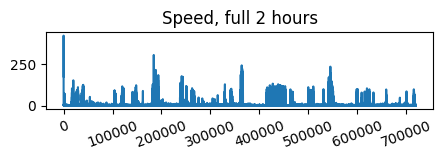

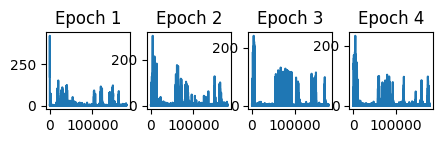

In [24]:
speed = np.load(root + '/data/speed_aln.npy', allow_pickle=True)[7]
plt.figure(figsize=(5, 1))
plt.title('Speed, full 2 hours')
plt.plot(speed[:720000])
plt.xticks(rotation=20);

plt.figure(figsize=(5, 1))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f'Epoch {i + 1}')
    plt.plot(speed[i*180000:(i + 1)*180000])

In [25]:
t1 = np.arange(len(speed)) / 100
t2 = np.arange(lastsamp - firstsamp + 1) / 2500
print(f'Behavior recording: {len(t1)} samples ({t1[-1]} sec)')
print(f'LFP recording: {len(t2)} samples ({t2[-1]} sec)')
print(f'LFP is longer by {t1[-1] - t2[-1]:.3f} sec')

interp = interp1d(t1, speed, kind='linear', fill_value='extrapolate')
speed = interp(t2)
speed = speed[:18000000:2]

Behavior recording: 720882 samples (7208.81 sec)
LFP recording: 18021771 samples (7208.708 sec)
LFP is longer by 0.102 sec


In [20]:
from kfx.load import load_potential
from kfx.lfp import clean_lfp, preprocess_lfp, compute_csd

In [89]:
chans = np.arange(firstchan, lastchan + 1)
lfp = load_potential(lfppath, startmin=0, endmin=1, offset=firstsamp, channels=chans)
lfp = clean_lfp(lfp)

In [90]:
lfp = preprocess_lfp(lfp)
csd = compute_csd(lfp)
X = (csd.values[:, :-1:2] + csd.values[:, 1::2]) / 2

In [186]:
sec = np.random.randint(60)
trial = X[sec*1250:(sec + 1) * 1250]

In [188]:
np.median(speed)

1.4144345827726021

In [193]:
np.percentile(speed, 90)

10.332059717260087

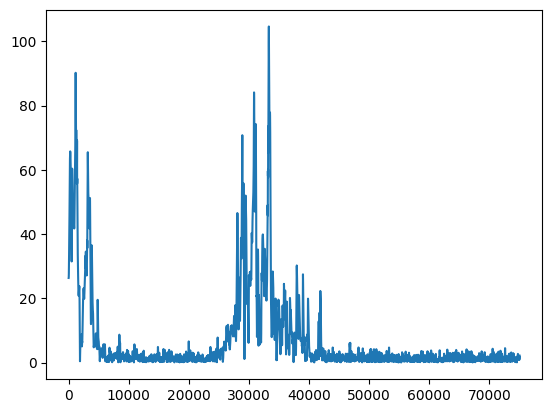

In [187]:
x = speed[sec*1250*60:(sec + 1)*1250*60]
plt.plot(x)

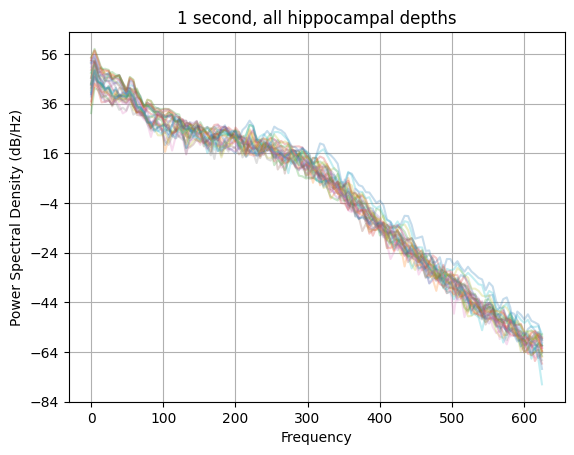

In [118]:
plt.figure()
plt.title('1 second, all hippocampal depths')
for i in range(trial.shape[1]):
    plt.psd(trial[:, i], Fs=1250, alpha=0.25)
plt.show()